In [29]:
import sqlite3
import pandas as pd
import os


conn = sqlite3.connect('/Users/dicordova/Documents/USFQ Data Science/Fundamentos/Proyecto FDS/notebooks/mydatabase.db')
query = "SELECT DISTINCT provincia FROM df_encoded"
provincia = pd.read_sql_query(query, conn)
print(provincia)
conn.close()


   provincia
0          5
1          6
2         12
3         13
4         17
5         18
6         23


In [30]:
import sqlite3
import pandas as pd

# Connect to your database
conn = sqlite3.connect('/Users/dicordova/Documents/USFQ Data Science/Fundamentos/Proyecto FDS/notebooks/mydatabase.db')

# Define the SQL query to load only one province (replace 'Pichincha' with the province you want)
query = """
SELECT * FROM df_encoded
WHERE provincia = '5'
ORDER BY RANDOM()
LIMIT 1000
"""

# Load the filtered data into a DataFrame
cotopaxi_df = pd.read_sql_query(query, conn)

# Preview the result
print(cotopaxi_df.head())

conn.close()


   provincia  canton_id  nro_vivienda  nro_hogar  espacio_cocina  \
0          5          1       62470.0        1.0             2.0   
1          5          7        4753.0        NaN             NaN   
2          5          1       19600.0        1.0             1.0   
3          5          4       27116.0        1.0             2.0   
4          5          1       77718.0        1.0             1.0   

   tiene_inodoro  tiene_ducha  combustible_cocina  fuente_agua_bebida  \
0            1.0          3.0                 4.0                 1.0   
1            NaN          NaN                 NaN                 NaN   
2            1.0          3.0                 1.0                 1.0   
3            1.0          3.0                 1.0                 1.0   
4            1.0          1.0                 1.0                 1.0   

   separa_basura_reciclaje  tiene_perros  tiene_gatos  tenencia_vivienda  \
0                      2.0           1.0          2.0                1.0   


In [31]:
# Show all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

cols_info = pd.DataFrame({
    'column': cotopaxi_df.columns,
    'dtype': cotopaxi_df.dtypes.values
})
print(cols_info.sort_values(by='dtype'))


                                                column    dtype
0                                            provincia    int64
146        tipo_vivienda_label_Otra vivienda colectiva    int64
147       tipo_vivienda_label_Otra vivienda particular    int64
148                         tipo_vivienda_label_Rancho    int64
149  tipo_vivienda_label_Residencia de adultos mayo...    int64
..                                                 ...      ...
30                                    total_personas_x  float64
29                                       total_mujeres  float64
27                                      nro_emigrantes  float64
41                                           mat_techo  float64
34                                            id_hogar   object

[230 rows x 2 columns]


In [32]:
with open('columns.txt', 'w') as f:
    for col in cotopaxi_df.columns:
        f.write(col + '\n')


Creamos un file de las columnas porque son muchas y el output sale truncado cada vez que intentamos explorarla para familiarizarnos con los nombres. 

In [33]:

# Create the summary DataFrame
col_info = pd.DataFrame({
    'Column Name': cotopaxi_df.columns,
    'Data Type': cotopaxi_df.dtypes.values,
    'Missing Values': cotopaxi_df.isna().sum().values
})

# Save it to a text file (tab-separated for readability)
col_info.to_csv('columns_info.txt', sep='\t', index=False)

# Optional: Preview in notebook
print(col_info)


                                           Column Name Data Type  \
0                                            provincia     int64   
1                                            canton_id     int64   
2                                         nro_vivienda   float64   
3                                            nro_hogar   float64   
4                                       espacio_cocina   float64   
..                                                 ...       ...   
225                   nro_cuartos_r_label_Tres cuartos     int64   
226                      nro_cuartos_r_label_Un cuarto     int64   
227     deficit_habitacional_label_Dignas o aceptables     int64   
228  deficit_habitacional_label_Déficit cualitativo...     int64   
229  deficit_habitacional_label_Déficit cuantitativ...     int64   

     Missing Values  
0                 0  
1                 0  
2                 0  
3               170  
4               170  
..              ...  
225               0  
226    

In [34]:
cols_a_remover = [col for col in cotopaxi_df.columns if (
    col.startswith('nro_cuartos_r_label_') or
    col.startswith('nro_emigrantes_label') or
    col.startswith('nro_hogar_label') or
    col.startswith('separa_basura') or
    col.startswith('fallecidos_ultimos_3_anios_label')
)]

cotopaxi_df = cotopaxi_df.drop(columns=cols_a_remover)


Después de sacar ciertas columnas, vamos a imputar los valores faltantes de las variables numéricas útiles para nuestro índice con KNN imputer. 

In [35]:
from sklearn.impute import KNNImputer

def imputar_knn_variables(cotopaxi_df, variables, n_neighbors=5):
    """
    Imputes missing values in the specified numerical columns using KNN.

    Parameters:
    - cotopaxi_df: pandas DataFrame
    - variables: list of column names to impute
    - n_neighbors: number of neighbors for KNNImputer (default: 5)

    Returns:
    - A DataFrame with the selected variables imputed.
    """
    cotopaxi_df = cotopaxi_df.copy()
    
    # Ensure all columns exist
    missing_cols = [col for col in variables if col not in cotopaxi_df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {missing_cols}")
    
    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    cotopaxi_df[variables] = imputer.fit_transform(cotopaxi_df[variables])
    
    return cotopaxi_df





In [36]:
variables_to_impute = [
    'nro_emigrantes',
    'total_personas_x',
    'nro_cuartos_r',
    'total_hombres',
    'total_mujeres',
    'nro_dormitorios_r'
]

cotopaxi_df = imputar_knn_variables(cotopaxi_df, variables_to_impute, n_neighbors=5)

Despues de la imputacion, vamos a sacar todos los valores NAN. Esta opcion se toma porque al haber imputado los valores ausentes en las variables numericas, podríamos usar el modo para las categóricas, pero no hay suficiente investigación para justificar esta decisión. Por lo tanto para el ejercicio las borraremos. 

In [37]:
cotopaxi_df_clean = cotopaxi_df.dropna().reset_index(drop=True)


Usamos KNN imputer para las variables numericas que usaremos en el modelo y en la construccion de variables compuestas. 

Creamos y combinamos varialbes en indicadores
Empezamos con hacinamiento. 

In [51]:
import numpy as np

# Evita división por cero o nulos
cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['total_personas_x'] / cotopaxi_df['nro_cuartos_r']
import numpy as np

cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['personas_por_cuarto'].replace([np.inf, -np.inf], np.nan)

# Crear categoría de hacinamiento
cotopaxi_df['hacinamiento'] = np.select(
    [
        cotopaxi_df['personas_por_cuarto'] <= 2,
        (cotopaxi_df['personas_por_cuarto'] > 2) & (cotopaxi_df['personas_por_cuarto'] < 4),
        cotopaxi_df['personas_por_cuarto'] >= 4
    ],
    ['Aceptable', 'Moderado', 'Severo'],
    default='Desconocido'
)

print(cotopaxi_df['personas_por_cuarto'].value_counts())



personas_por_cuarto
1.000000     212
1.131950     170
2.000000      86
0.500000      82
1.500000      60
1.333333      44
0.666667      40
0.750000      35
3.000000      34
0.333333      32
1.250000      25
2.500000      24
4.000000      23
0.600000      21
1.666667      20
0.800000      19
1.200000       9
0.200000       9
0.400000       8
3.500000       7
5.000000       7
2.333333       5
1.750000       5
0.250000       5
0.833333       3
0.166667       2
2.666667       2
2.250000       2
1.400000       2
14.000000      1
6.000000       1
4.500000       1
7.000000       1
5.500000       1
3.333333       1
1.600000       1
Name: count, dtype: int64


In [52]:
print(cotopaxi_df['hacinamiento'].unique())

['Severo' 'Aceptable' 'Moderado']


In [39]:
hacinamiento_map = {'Aceptable': 0, 'Moderado': 1, 'Severo': 2, 'Desconocido': np.nan}
cotopaxi_df['hacinamiento_score'] = cotopaxi_df['hacinamiento'].map(hacinamiento_map)
print(cotopaxi_df[['hacinamiento', 'hacinamiento_score']].head(10))

  hacinamiento  hacinamiento_score
0       Severo                 2.0
1    Aceptable                 0.0
2    Aceptable                 0.0
3    Aceptable                 0.0
4    Aceptable                 0.0
5    Aceptable                 0.0
6    Aceptable                 0.0
7    Aceptable                 0.0
8    Aceptable                 0.0
9     Moderado                 1.0


In [40]:
# Definir las columnas que indican vulnerabilidad
cols_vulnerables = [
    # Materiales precarios
    'mat_techo_label_Palma, paja u hoja',
    'mat_techo_label_Otro material',
    'mat_paredes_label_Caña no revestida',
    'mat_paredes_label_Adobe o tapia',
    'mat_paredes_label_Otro material',
    'mat_piso_label_Tierra',
    'mat_piso_label_Caña sin tratar',
    'mat_piso_label_Otro material',

    # Estados "Malos"
    'estado_techo_label_Malo',
    'estado_paredes_label_Malo',
    'estado_piso_label_Malo',

    # Ocupación inestable
    'ocup_viv_part_label_De temporada o vacacional',
    'ocup_viv_part_label_Ocupada con personas ausentes',
    'ocup_viv_colect_label_Sin residentes habituales'
]

# Asegurarnos de que las columnas existen
cols_vulnerables = [col for col in cols_vulnerables if col in cotopaxi_df.columns]

# Sumar como score
cotopaxi_df['vulnerabilidad_vivienda'] = cotopaxi_df[cols_vulnerables].sum(axis=1)


In [41]:
cotopaxi_df['nivel_vulnerabilidad_vivienda'] = pd.cut(
    cotopaxi_df['vulnerabilidad_vivienda'],
    bins=[-1, 1, 3, 5, np.inf],
    labels=['Baja', 'Media-baja', 'Media-alta', 'Alta']
)
print(cotopaxi_df[['vulnerabilidad_vivienda', 'nivel_vulnerabilidad_vivienda']].head(10))

   vulnerabilidad_vivienda nivel_vulnerabilidad_vivienda
0                        0                          Baja
1                        1                          Baja
2                        0                          Baja
3                        0                          Baja
4                        0                          Baja
5                        0                          Baja
6                        0                          Baja
7                        0                          Baja
8                        0                          Baja
9                        1                          Baja


In [42]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean.reset_index(drop=True)

cotopaxi_df_clean = remove_outliers_iqr(cotopaxi_df, ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score'])


In [43]:
print("Antes de remover outliers:", cotopaxi_df.shape)
print("Después de remover outliers:", cotopaxi_df_clean.shape)


Antes de remover outliers: (1000, 223)
Después de remover outliers: (832, 223)


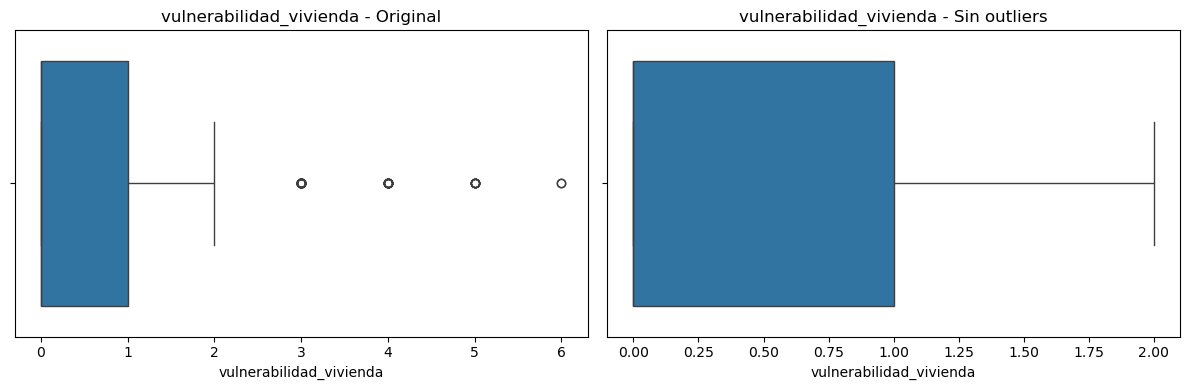

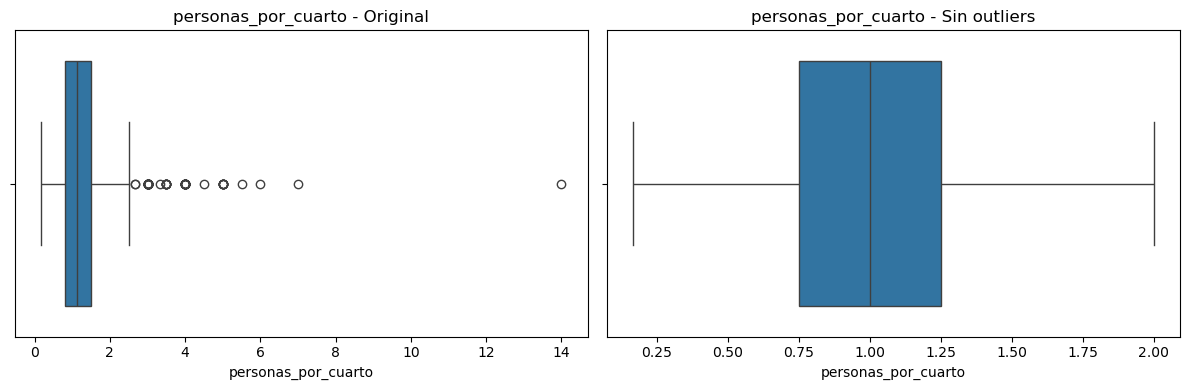

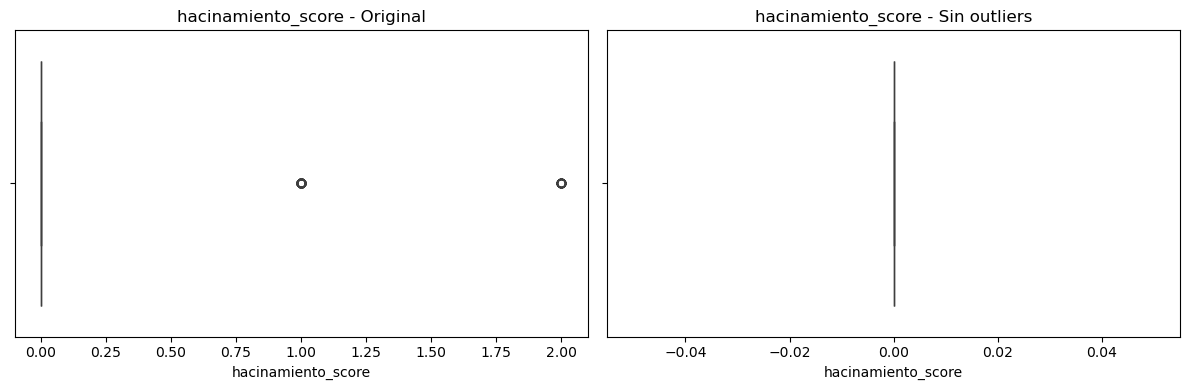

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score']

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.boxplot(x=cotopaxi_df[var], ax=axes[0])
    axes[0].set_title(f'{var} - Original')

    sns.boxplot(x=cotopaxi_df_clean[var], ax=axes[1])
    axes[1].set_title(f'{var} - Sin outliers')

    plt.tight_layout()
    plt.show()


Esta transformación se hizo para: 
Para resumir vulnerabilidad en 4 niveles simples.

Para visualización (gráficos de barras, mapas coropléticos).

Para perfilar clusters usando métodos no supervisados.

In [46]:
from sklearn.preprocessing import StandardScaler

# Selecciona las variables que representan vulnerabilidad
variables_cluster = [
    'vulnerabilidad_vivienda',
    'personas_por_cuarto'
    #'hacinamiento_score'
]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cotopaxi_df_clean[variables_cluster])
X_scaled  # Muestra las primeras 5 filas del array escalado

array([[ 1.01743272,  0.16044884],
       [-0.70310391, -0.1424604 ],
       [-0.70310391, -0.1424604 ],
       ...,
       [ 1.01743272,  0.16044884],
       [-0.70310391, -1.29027683],
       [-0.70310391, -0.1424604 ]])

In [47]:
cotopaxi_df_clean[variables_cluster]
cotopaxi_df_clean['hacinamiento_score'].value_counts()

hacinamiento_score
0.0    832
Name: count, dtype: int64

In [53]:
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_cluster, index=cotopaxi_df_clean.index)


In [54]:
from sklearn.cluster import KMeans

# Inicializa KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300)
kmeans.fit(cotopaxi_df_clean[variables_cluster])
cotopaxi_df_clean['cluster_kmeans'] = kmeans.labels_

In [60]:
#Evaluamos los cluster
cotopaxi_df_clean.groupby('cluster_kmeans')[variables_cluster].mean().round(2)


,vulnerabilidad_vivienda,personas_por_cuarto
cluster_kmeans,,
0,0.0,0.73
1,2.0,1.20
2,0.0,1.58
3,1.0,1.15


Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación

0	0.0	0.73	Vivienda estable, poco hacinamiento ✅

1	2.0	1.20	Alta vulnerabilidad en vivienda ⚠️

2	0.0	1.58	Vivienda buena, pero muy hacinados 🔥

3	1.0	1.15	Vulnerabilidad media, hacinamiento moderado



In [56]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=4)
cotopaxi_df_clean['cluster_agglo'] = agglo.fit_predict(X_scaled)


In [61]:
#evaluamos los cluster
cotopaxi_df_clean.groupby('cluster_agglo')[variables_cluster].mean().round(2)


,vulnerabilidad_vivienda,personas_por_cuarto
cluster_agglo,,
0,1.13,1.15
1,0.00,1.19
2,0.00,0.55
3,0.00,2.00


Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación

0	1.13	1.15	Mixto, media vulnerabilidad 🟠

1	0.00	1.19	Vivienda buena, hacinamiento leve ✅

2	0.00	0.55	Vivienda buena, poco hacinamiento 🟢

3	0.00	2.00	Vivienda buena, pero severamente hacinados 🔴

In [62]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Suponiendo que ya tienes X_scaled (si no, escálalo así):
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(cotopaxi_df_clean[variables_cluster])

# MiniBatchKMeans con 4 clusters
mb_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
mb_kmeans.fit(X_scaled)

# Guardamos etiquetas
cotopaxi_df_clean['cluster_minibatch'] = mb_kmeans.labels_


In [63]:
#evaluamos los cluster
cotopaxi_df_clean.groupby('cluster_minibatch')[variables_cluster].mean().round(2)

,vulnerabilidad_vivienda,personas_por_cuarto
cluster_minibatch,,
0,1.50,1.82
1,0.00,1.32
2,1.09,1.08
3,0.00,0.55


Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación resumida

0	1.50	1.82	Alta vulnerabilidad y hacinamiento grave 🔥

1	0.00	1.32	Vivienda adecuada, pero con cierto hacinamiento ⚠️

2	1.09	1.08	Vulnerabilidad media, hacinamiento moderado 🟠

3	0.00	0.55	Vivienda adecuada y poco hacinamiento ✅

Cluster 0 probablemente concentra a las familias en mayor situación de riesgo: malas condiciones de vivienda y muchas personas por cuarto.

Cluster 3 parece ser el más seguro o resiliente.

Cluster 1 muestra hacinamiento con vivienda aceptable, algo interesante: podrían ser hogares informales o con dinámicas familiares complejas.

Cluster 2 está en el centro, un mix.

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducimos a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Añadir coordenadas PCA al DataFrame para trazarlos
cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
cotopaxi_df_clean['PCA2'] = X_pca[:, 1]


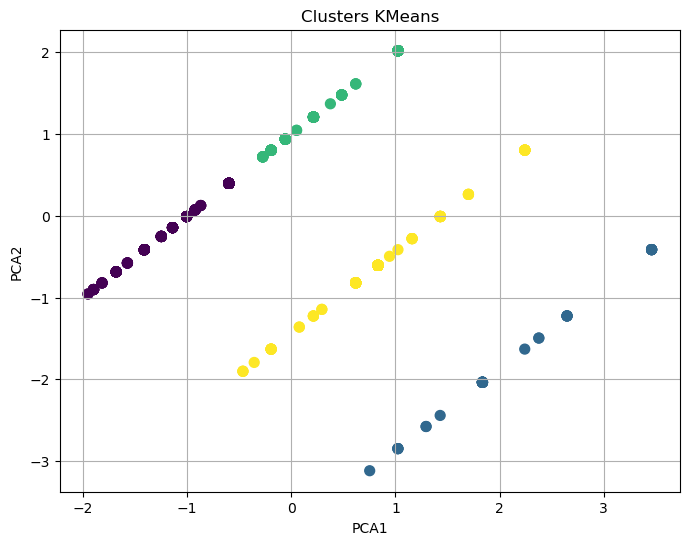

In [58]:
plt.figure(figsize=(8,6))
plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'], 
            c=cotopaxi_df_clean['cluster_kmeans'], cmap='viridis', s=50)
plt.title('Clusters KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()


Del gráfico podemos concluir: 
Cuando hago PCA, estoy transformando mis datos multivariados a un nuevo sisstema de coordinadas, que resume la mayor cantidad de variabilidad en pocas dimensiones. Aquí se indica que los clusters están bien separados en el espacio PCA, es decir no hay solapación en los grupos. Hay una estructural natural en los grupos que Kmeans parece haber capturado bien. 

Esto puede deberse gracias a que: 
Las variables tienen una relación continua (como pobreza o hacinamiento) o cuando hay un patrón jerárquico entre observaciones

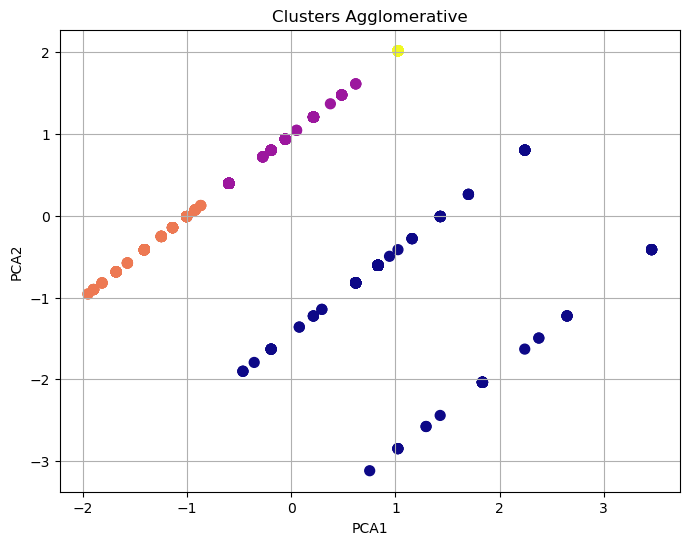

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'], 
            c=cotopaxi_df_clean['cluster_agglo'], cmap='plasma', s=50)
plt.title('Clusters Agglomerative')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()


Del gráfico podemos concluir que: 
Los clusters están más desequilibrados comparados con los de KMeans

Un color (azul oscuro) parece agrupar a la mayoría de los puntos. Otros clusters (amarillo brillante, morado, rosado) tienen muy pocos elementos. El cluster amarillo parece ser un outlier solitario → probablemente una observación única y muy distinta.

Tiende a formar clusters jerárquicos, lo que a veces agrupa muchos puntos en uno grande y deja pocos pequeños.

Es sensible a la escala y a la densidad

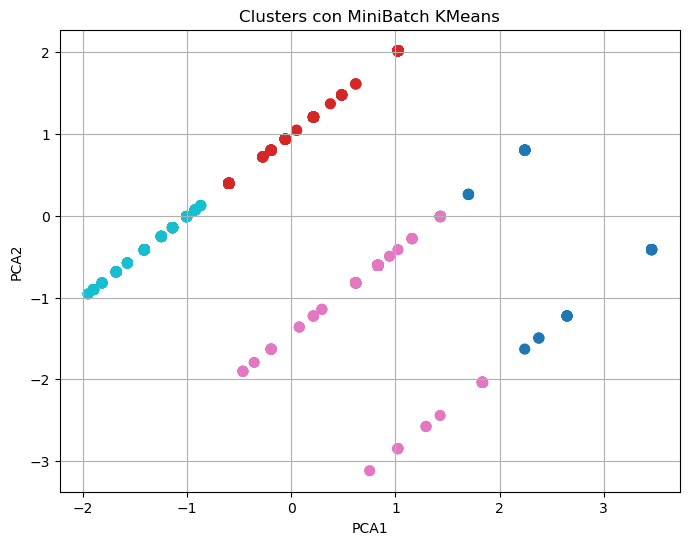

In [64]:
# Reducimos a 2D para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
cotopaxi_df_clean['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'],
            c=cotopaxi_df_clean['cluster_minibatch'], cmap='tab10', s=50)
plt.title('Clusters con MiniBatch KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()


Del gráfico podemos concluir que: 

Visualmente, puedes decir que hay al menos 4 poblaciones distintas en cuanto a vulnerabilidad (por ejemplo: alto hacinamiento y mala vivienda vs. baja vulnerabilidad).

In [65]:
mapa_labels = {
    0: 'Crítico',
    1: 'Moderado: hacinamiento con vivienda adecuada',
    2: 'Vulnerabilidad media',
    3: 'Condiciones adecuadas'
}


In [66]:
cotopaxi_df_clean['perfil_minibatch'] = cotopaxi_df_clean['cluster_minibatch'].map(mapa_labels)


In [67]:
cotopaxi_df_clean['perfil_minibatch'].value_counts()


perfil_minibatch
Moderado: hacinamiento con vivienda adecuada    318
Vulnerabilidad media                            268
Condiciones adecuadas                           214
Crítico                                          32
Name: count, dtype: int64

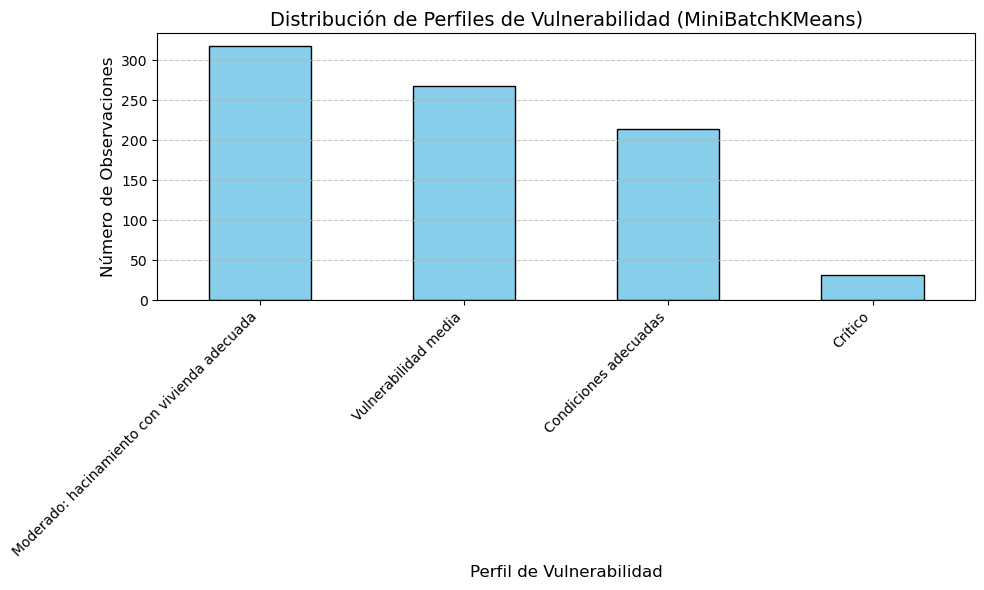

In [68]:
import matplotlib.pyplot as plt

# Contar cuántos hay por perfil
conteo_perfiles = cotopaxi_df_clean['perfil_minibatch'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(10,6))
conteo_perfiles.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribución de Perfiles de Vulnerabilidad (MiniBatchKMeans)', fontsize=14)
plt.xlabel('Perfil de Vulnerabilidad', fontsize=12)
plt.ylabel('Número de Observaciones', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Al comparar los tres modelos parece ser mejor al MiniBatchKmeans. En este caso no tenemos métricas como en los modelos de regresión, sin embargo este modelo nos permite: 
Escalar a millones de datos (necesario, dado que el censo tienen al menos 3millones de datos para las 5 provincias que están involucradas)

Identifica poblaciones altamente vulnerables al detectar los perfiles de cluster como el número de personas por habitación o vulnerabilidades de vivienda. 

Sin embargo, el modelo de Agglomerative mostró sensibilidad ante los outliers. Es decir, podría ser usado en muestras de datos más pequeñas que permitan reafinar perfiles e identificar la vulnerabilidad por zonas geográficas más pequeñas. Es decir, en lugar de decir "la provincia de Cotopaxi es vulnerable" podemos decir, la Provincia de Cotopaxi, en la ciudad de Latacunga y su cantón X tiene una granconcentración de viviendas/hogares vulnerables" lo que es precisamente más útil al momento de diseñar política pública. 

Esto es importante tomar en cuenta para poder hacer un mapeo de los clusters. Algo que podría hacerse en un paso posterior. 